# Evaluating the Predictive Capabilities of "Predictive Testing"
## Predicting NCLEX Success for Nursing Students
Author: Alexander Stachniak

# Model Building and Analysis Stage
As we begin fitting our data to determine the best model, we should understand which metrics will be used in evaluation. First, we will use hyperparameter tuning to help find the best set of parameters for various models (e.g. l1 or l2 penalty for Logistic Regression). Within those tests, we will rely on F1-Weighted score to determine the best set of parameters. F1-Weighted score helps to balance between precision and recall for both the minority and majority class, important when we have such a large class imbalance.

To compare between model types, we will review Confusion Matrices and Classification Reports as a way to understand the relative strengths and weaknesses of each model. Of special importance to us will be recall of the minority class (i.e. we want to catch as many future failures as we can) and precision of the majority class (i.e. we don't want to mistakenly predict that remediation is not necessary for a student who eventually fails).


## Goals
* Fit data using a variety of predictive modeling techniques
* Based on appropriate evaluation metrics, determine the best predictive model for our data
* Analyze the results

# Modules
All Python modules used are fairly common and will be installed as a default for users running Anaconda.

### Exception: probability_boundary
The probability_boundary library is a self-built class that calculates probability boundary scores and has its own plotting method. Here we import to Jupyter Notebook using the %run magic function.

### Exception: imblearn
The exception is imblearn, an open source implementation of sampling methods (http://contrib.scikit-learn.org/imbalanced-learn/index.html). This project makes use of imblearn's implementation of SMOTE.
#### Installation is simple:
pip install -U imbalanced-learn

In [64]:
# Standard modules
import pandas as pd
import numpy as np
import pickle
import datetime

# Import probability_boundary Library
%run probability_boundary.py

# Plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Display plots within Jupyter Notebook
%matplotlib inline
# Set default plot size
plt.rcParams['figure.figsize'] = (14, 5)
# Seaborn used for its excellent correlation heatmap plot
import seaborn as sns

# SciKit Learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import scale, Imputer, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC

# One module from SciPy used for calculating percentile scores
from scipy.stats import percentileofscore

# An open source implementation of sampling methods
# http://contrib.scikit-learn.org/imbalanced-learn/index.html
from imblearn.over_sampling import SMOTE

# For display of mathematical formulae
from IPython.display import Math

# Caution: use only when certain of results
import warnings
warnings.filterwarnings('ignore')

# Functions to Assist in Model Building
The functions below are designed to standardize the model building process to make evaluation and comparison much easier. 

In [66]:
def plot_roc_auc (y_pred_prob, y_true, width=14, height=5, subplot=111):
    '''Function produces a plot of Receiver Operating Characteristic (ROC)
    Area Under the Curve (AUC) using functions from SciKit Learn.
    
    @ Parameters:
    ------------------
        y_pred_prob: array of probability scores for each class
        y_true: array of true class values
        width: width of plot in inches
        height: height of plot in inches
        subplot: three-digit shorthand for subplot
    '''

    # Number of unique classes
    n_classes = len(y_true.unique())
    # Dictionary storage
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Calculate ROC and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob[:,i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Set default plot size
    plt.rcParams['figure.figsize'] = (width, height)

    # Plot ROC Curve and Area
    plt.subplot(subplot)
    colors = ['red', 'blue']
    # Plot ROC for each class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, alpha=0.6, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    # Plot the "luck" line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Blind Luck')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)\nArea Under the Curve (AUC)')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
def display_prediction_probabilities (data_dict, model, term):
    '''A function that displays a side-by-side plot of probability boundaries
    and ROC curve.'''
    # Define names
    pred_name = model + '_pred'
    pred_prob_name = model + '_pred_prob'
    
    # Plot probability boundaries
    pb = probability_boundary(data_dict[term][pred_prob_name], data_dict[term]['y_test'])
    pb.plot(subplot=121)
    pb
    
    # Plot ROC AUC
    roc_auc = plot_roc_auc(data_dict[term][pred_prob_name], data_dict[term]['y_test'], subplot=122)
    roc_auc

In [68]:
def fit_models (df_dict, x, y, val_x, val_y, clf_model, clf_name, clf_abbrev, clf_params, scoring_method, scoring_name):
    '''Function takes as input our data dictionary, model, and scoring function and outputs
    various scoring metrics, including confusion matrix and classification report, and also
    plots the probability boundaries of our classifier as well as an overall cross-validation
    plot.'''
    # Initialize GridSearchCV
    clf_gs = GridSearchCV(clf_model,param_grid=clf_params,cv=5,scoring=scoring_method)
    
    # Set names
    model = clf_abbrev + '_model'
    predictions = clf_abbrev + '_pred'
    predict_prob = clf_abbrev + '_pred_prob'
    train_scores = clf_abbrev + '_train_scores'
    test_scores = clf_abbrev + '_test_scores'
    
    print('Model:', clf_name)
    for term in range(1, 8):
        # Fit the data
        print('Term:', term)
        clf_gs.fit(df_dict[term][x], df_dict[term][y])
        print('Best Score: {0:5.2f}%'.format(clf_gs.best_score_*100))
        print('Best Estimator:', clf_gs.best_estimator_)
        df_dict[term][model] = clf_gs.best_estimator_
        # Fit the best estimator and make predictions
        df_dict[term][model].fit(df_dict[term][x], df_dict[term][y])
        df_dict[term][predictions] = df_dict[term][model].predict(df_dict[term][val_x])
        df_dict[term][predict_prob] = df_dict[term][model].predict_proba(df_dict[term][val_x])
        df_dict[term][train_scores] = cross_val_score(df_dict[term][model], df_dict[term][x], df_dict[term][y], cv=5, scoring=scoring_method)
        df_dict[term][test_scores] = cross_val_score(df_dict[term][model], df_dict[term][val_x], df_dict[term][val_y], cv=5, scoring=scoring_method)
        # Print results
        print('Confusion Matrix:')
        print(confusion_matrix(df_dict[term][val_y], df_dict[term][predictions]))
        print('\nClassification Report:')
        print(classification_report(df_dict[term][val_y], df_dict[term][predictions]))
        # Plot probability boundaries and ROC Curve
        display_prediction_probabilities(df_dict, clf_abbrev, term)
        
    # Gather means and standard deviations using list comprehension
    terms = np.arange(1,8,1)
    train_mean = np.array([np.mean(df_dict[x][train_scores]) for x in terms])
    train_std = np.array([np.std(df_dict[x][train_scores]) for x in terms])
    test_mean = np.array([np.mean(df_dict[x][test_scores]) for x in terms])
    test_std = np.array([np.std(df_dict[x][test_scores]) for x in terms])
    
    # Plot the training and validation scores with standard deviation
    plt.plot(terms, train_mean, color='blue', marker='o', markersize=5, label='Training ' + scoring_name)
    plt.fill_between(terms, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(terms, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation ' + scoring_name)
    plt.fill_between(terms, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    # Set y axis range to keep on same scale
    plt.ylim([0.60,1.00])
    plt.grid()
    plt.title(clf_name)
    plt.xlabel('Term')
    plt.ylabel(scoring_name + ' score')
    plt.legend(loc='best')
    plt.show()

# Load Data

In [65]:
with open('df_dict.pickle', 'rb') as file:
    df_dict = pickle.load(file)

Model: Logistic Regression
Term: 1
Best Score: 79.88%
Best Estimator: LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)
Confusion Matrix:
[[16  3]
 [28 92]]

Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.84      0.51        19
          1       0.97      0.77      0.86       120

avg / total       0.89      0.78      0.81       139



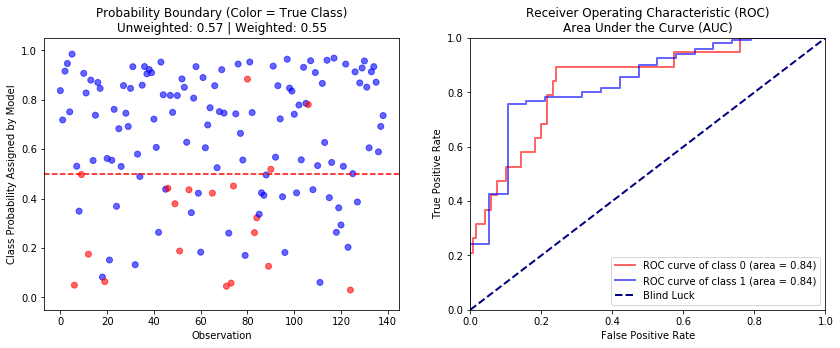

Term: 2
Best Score: 79.78%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
Confusion Matrix:
[[11  8]
 [28 92]]

Classification Report:
             precision    recall  f1-score   support

          0       0.28      0.58      0.38        19
          1       0.92      0.77      0.84       120

avg / total       0.83      0.74      0.77       139



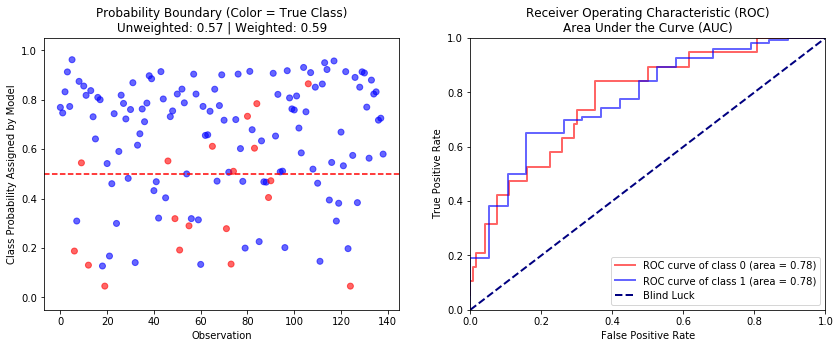

Term: 3
Best Score: 80.66%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
Confusion Matrix:
[[12  7]
 [24 96]]

Classification Report:
             precision    recall  f1-score   support

          0       0.33      0.63      0.44        19
          1       0.93      0.80      0.86       120

avg / total       0.85      0.78      0.80       139



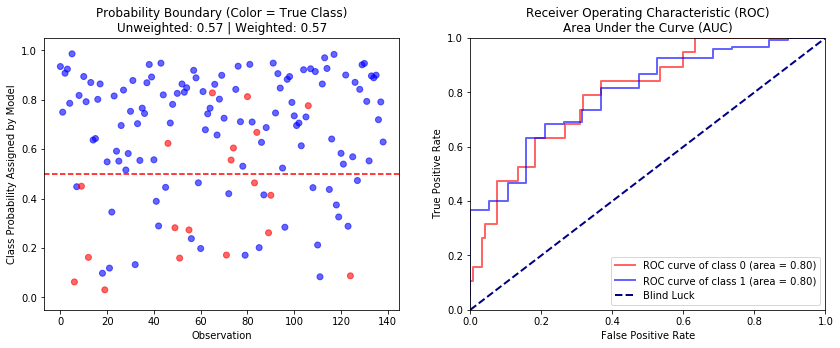

Term: 4
Best Score: 80.63%
Best Estimator: LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)
Confusion Matrix:
[[13  6]
 [23 97]]

Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.68      0.47        19
          1       0.94      0.81      0.87       120

avg / total       0.86      0.79      0.82       139



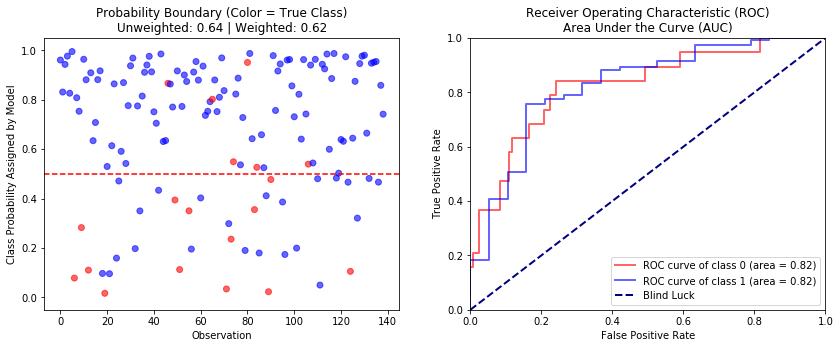

Term: 5
Best Score: 82.28%
Best Estimator: LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
Confusion Matrix:
[[ 8 11]
 [23 97]]

Classification Report:
             precision    recall  f1-score   support

          0       0.26      0.42      0.32        19
          1       0.90      0.81      0.85       120

avg / total       0.81      0.76      0.78       139



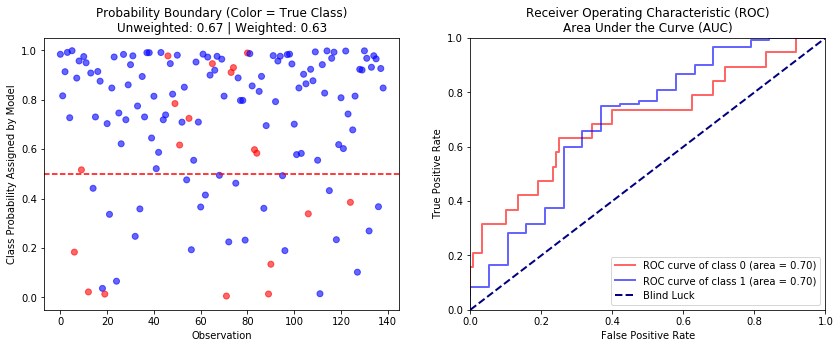

Term: 6
Best Score: 80.98%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
Confusion Matrix:
[[10  9]
 [24 96]]

Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.38        19
          1       0.91      0.80      0.85       120

avg / total       0.83      0.76      0.79       139



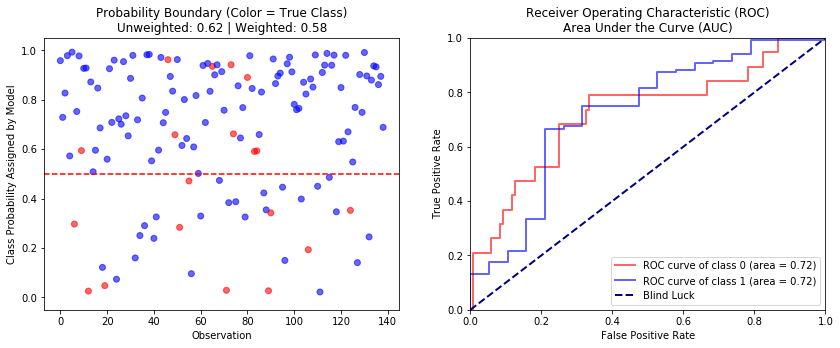

Term: 7
Best Score: 81.43%
Best Estimator: LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
Confusion Matrix:
[[10  9]
 [25 95]]

Classification Report:
             precision    recall  f1-score   support

          0       0.29      0.53      0.37        19
          1       0.91      0.79      0.85       120

avg / total       0.83      0.76      0.78       139



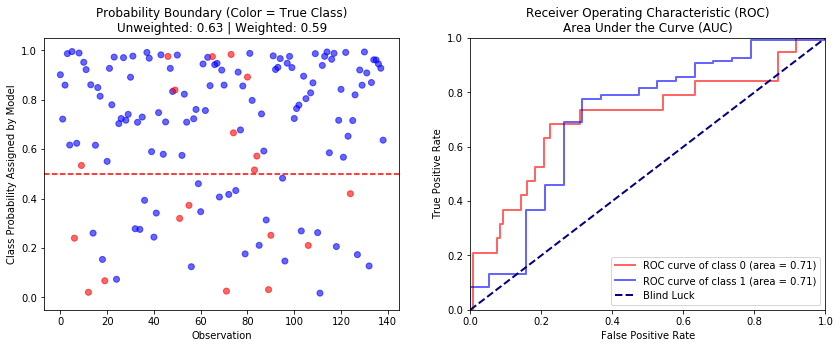

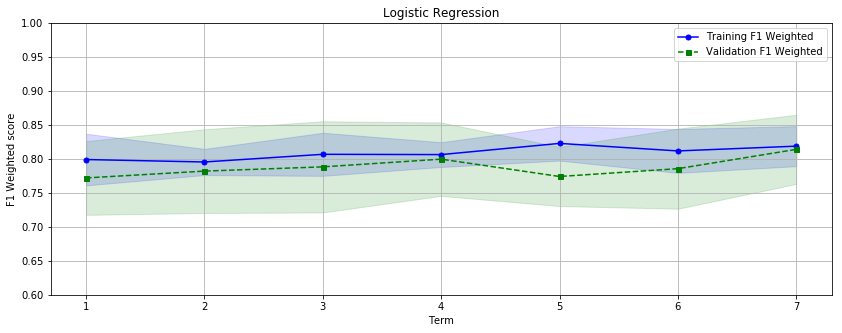

In [69]:
# Set parameters and initialize model
log_params = {'C':[1, 10, 100, 1000],
              'tol':[1e-1,1e-2,1e-3,1e-4],
              'penalty':['l1', 'l2'],
              'class_weight': ['balanced']
              }
log = LogisticRegression(n_jobs=-1)
fit_models(df_dict, 'x_train', 'y_train', 'x_test', 'y_test', log, 'Logistic Regression', 'log', log_params, 'f1_weighted', 'F1 Weighted')

In [6]:
# Pickle the data for future use
with open('df_dict.pickle', 'wb') as f:
    pickle.dump(df_dict, f, pickle.HIGHEST_PROTOCOL)